In [3]:
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt; import seaborn as sns

### Validate through simulation

Here we simulate a situation where Y is caused by X and and an unmeasured confound U that also effects Z and X. (We could also prove mathematically, but simulation is quite confincing as well--for me anyways)

$$
\begin{align*}
U &\sim \text{Bernoulli}(0.5) \\
Z &\sim \text{Normal}(\beta_{UZ}U, 1) \\
X &\sim \text{Normal}(\beta_{ZX}Z, 1) \\
Y &\sim \text{Normal}(\alpha + \beta_{XY}X + \beta_{UY}U, 1) \\
\end{align*}
$$

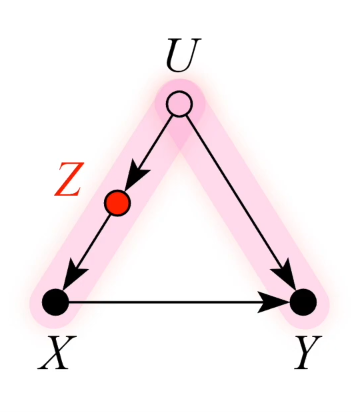

In [4]:
np.random.seed(123)
n_samples = 200

alpha = 0
beta_XY = 0 # CAUSAL EFFECT OF X ON Y = 0
beta_UY = -1 # CAUSAL EFFECT OF THE CONFOUND (U) ON Y AND Z IS NEGATIVE
beta_UZ = -1
beta_ZX = 1 # CAUSAL EFFECT OF Z ON X IS POSITIVE (!)

U = stats.bernoulli.rvs(p=.5, size=n_samples)
Z = stats.norm.rvs(loc=beta_UZ * U)
X = stats.norm.rvs(loc=beta_ZX * Z)
Y = stats.norm.rvs(loc=alpha + beta_XY * X + beta_UY * U)

<Axes: >

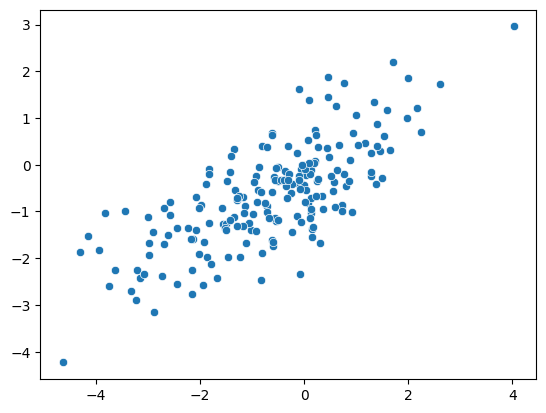

In [5]:
sns.scatterplot(x=X, y=Z)

### Unstratified (confounded) Model: Ignoring U and Z

$$
\begin{align*}
Y &\sim \text{Normal}(\mu_Y, \sigma_Y) \\
\mu_Y &= \alpha + \beta_{XY}X \\
\alpha &\sim \text{Normal}(0, 1) \\
\beta_{XY} &\sim \text{Normal}(0, 1) \\
\sigma_Y &\sim \text{Exponential}(1)
\end{align*}
$$

In [6]:
with pm.Model() as unstratified_model:
    # Priors
    alpha_ = pm.Normal("alpha", 0, 1)
    beta_XY_ = pm.Normal("beta_XY", 0, 1)
    sigma_ = pm.Exponential("sigma", 1)
    
    # Likelihood
    mu_ = alpha_ + beta_XY_ * X
    Y_ = pm.Normal("Y", mu=mu_, sigma=sigma_, observed=Y)
    unstratified_model_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_XY, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [7]:
az.summary(unstratified_model_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.383,0.085,-0.535,-0.220,0.002,0.002,1606.0,1396.0,1.0
beta_XY,0.146,0.052,0.048,0.244,0.001,0.001,1688.0,1640.0,1.0
sigma,1.115,0.057,1.006,1.214,0.001,0.001,2611.0,1697.0,1.0


### Stratifying by Z (unconfounded)


$$
\begin{align*}
Y &\sim \text{Normal}(\mu_Y, \sigma_Y) \\
\mu_Y = &\alpha + \beta_{XY}X + \beta_{Z}Z \\
\alpha &\sim \text{Normal}(0, 1) \\
\beta_{*} &\sim \text{Normal}(0, 1) \\
\sigma_Y &\sim \text{Exponential}(1)
\end{align*}
$$

In [8]:
# Fit the stratified Model
with pm.Model() as stratified_model:
    # Priors
    alpha_ = pm.Normal("alpha", 0, 1)
    beta_XY_ = pm.Normal("beta_XY", 0, 1)
    beta_Z_ = pm.Normal("beta_Z", 0, 1)
    sigma_ = pm.Exponential("sigma", 1)
    
    # Likelihood (includes Z)
    mu_ = alpha_ + beta_XY_ * X + beta_Z_ * Z
    Y_ = pm.Normal("Y", mu=mu_, sigma=sigma_, observed=Y)
    stratified_model_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_XY, beta_Z, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [9]:
az.summary(stratified_model_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.287,0.090,-0.457,-0.119,0.002,0.002,1589.0,1199.0,1.0
beta_XY,-0.027,0.078,-0.160,0.132,0.002,0.002,1247.0,1127.0,1.0
beta_Z,0.320,0.107,0.130,0.519,0.003,0.002,1435.0,1353.0,1.0
sigma,1.089,0.052,0.987,1.185,0.001,0.001,1652.0,1228.0,1.0


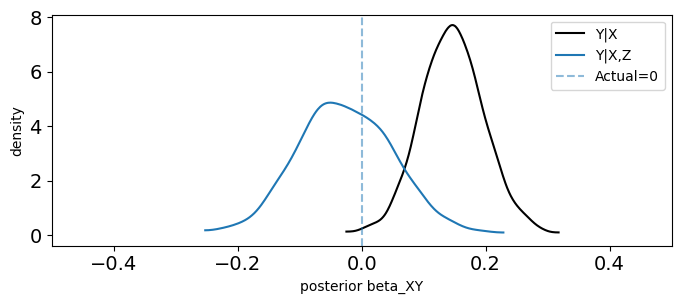

In [10]:
_, ax = plt.subplots(figsize=(8, 3))
az.plot_dist(unstratified_model_inference.posterior.beta_XY, color='k', label='Y|X', ax=ax)
az.plot_dist(stratified_model_inference.posterior.beta_XY, color='C0', label='Y|X,Z', ax=ax)
plt.axvline(beta_XY, color='C0', linestyle='--', alpha=.5, label=f"Actual={beta_XY}")
plt.xlim([-.5, .5])
plt.xlabel("posterior beta_XY")
plt.ylabel("density")
plt.legend();

#### Bad Control

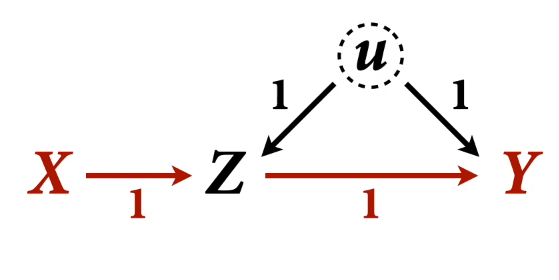

In [11]:
beta_XZ = 1
beta_ZY = 0

u = stats.norm.rvs(size=n_samples)
X = stats.norm.rvs(size=n_samples)

# # causal effect of X on Z
mu_Z = X * beta_XZ + u
Z = stats.norm.rvs(size=n_samples, loc=mu_Z)

# # Causal effect of Z on Y (including confound)
mu_Y = Z * beta_ZY + u
Y = stats.norm.rvs(size=n_samples, loc=mu_Y)

# # Put data into format for statsmodels
data = pd.DataFrame(np.vstack([Y, X, Z, u]).T, columns=["Y", "X", "Z", "u"])

unstratified_model = smf.ols("Y ~ X", data=data).fit()
stratified_model = smf.ols("Y ~ X + Z", data=data).fit()

In [12]:
unstratified_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.686
Date:                Thu, 05 Dec 2024   Prob (F-statistic):              0.103
Time:                        13:27:19   Log-Likelihood:                -348.94
No. Observations:                 200   AIC:                             701.9
Df Residuals:                     198   BIC:                             708.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0688      0.098     -0.699      0.486      -0.263       0.125
X              0.1666      0.102      1.639      0.103      -0.034       0.367
==============================================================================
Omnibus:                        0.694   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.707   Jarque-Bera (JB):                0.516
Skew:                          -0.120   Prob(JB):                        0.773
Kurtosis:                       3.063   Cond. No.                         1.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
stratified_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     47.35
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           1.62e-17
Time:                        13:27:19   Log-Likelihood:                -311.04
No. Observations:                 200   AIC:                             628.1
Df Residuals:                     197   BIC:                             638.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0272      0.082      0.331      0.741      -0.135       0.189
X             -0.4343      0.105     -4.124      0.000      -0.642      -0.227
Z              0.6246      0.066      9.528      0.000       0.495       0.754
==============================================================================
Omnibus:                        0.057   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.064
Skew:                          -0.037   Prob(JB):                        0.968
Kurtosis:                       2.952   Cond. No.                         2.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
def simulate_bad_mediator(beta_XZ, beta_ZY, n_samples=100):
    # independent variables
    u = stats.norm.rvs(size=n_samples)
    X = stats.norm.rvs(size=n_samples)
    
    # causal effect of X on Z
    mu_Z = X * beta_XZ + u
    Z = stats.norm.rvs(size=n_samples, loc=mu_Z)
    
    # Causal effect of Z on Y (including confound)
    mu_Y = Z * beta_ZY + u
    Y = stats.norm.rvs(size=n_samples, loc=mu_Y)
    
    # Put data into format for statsmodels
    data = pd.DataFrame(np.vstack([Y, X, Z, u]).T, columns=["Y", "X", "Z", "u"])
    
    unstratified_model = smf.ols("Y ~ X", data=data).fit()
    stratified_model = smf.ols("Y ~ X + Z", data=data).fit()
    
    return unstratified_model.params.X, stratified_model.params.X

def run_bad_mediator_simulation(beta_XZ=1, beta_ZY=1, n_simulations=500, n_samples_per_simualtion=100):
    beta_X = beta_XZ * beta_ZY

    simulations = np.array(
        [
            simulate_bad_mediator(beta_XZ=beta_XZ, beta_ZY=beta_ZY, n_samples=n_samples_per_simualtion) 
            for _ in range(n_simulations)
        ]
    )
    _, ax = plt.subplots(figsize=(8, 4))
    az.plot_dist(simulations[:, 0], label='Y ~ X\ncorrect', color='black', ax=ax)
    az.plot_dist(simulations[:, 1], label='Y ~ X + Z\nwrong', color="C0", ax=ax)
    plt.axvline(beta_X, color='k', linestyle='--', label=f'actual={beta_X}')
    plt.legend(loc='upper left')
    plt.xlabel("posterior mean")
    plt.ylabel("density");

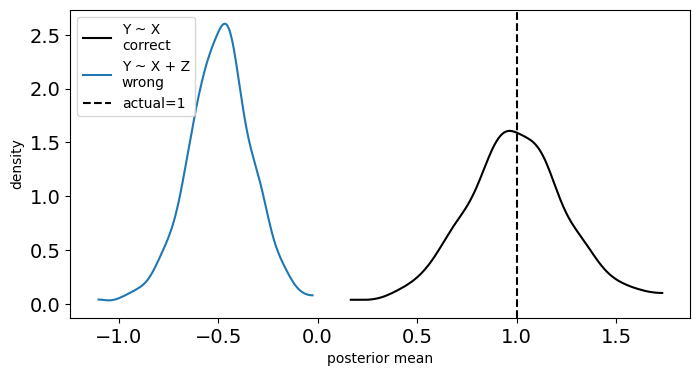

In [15]:
run_bad_mediator_simulation(beta_XZ=1, beta_ZY=1)

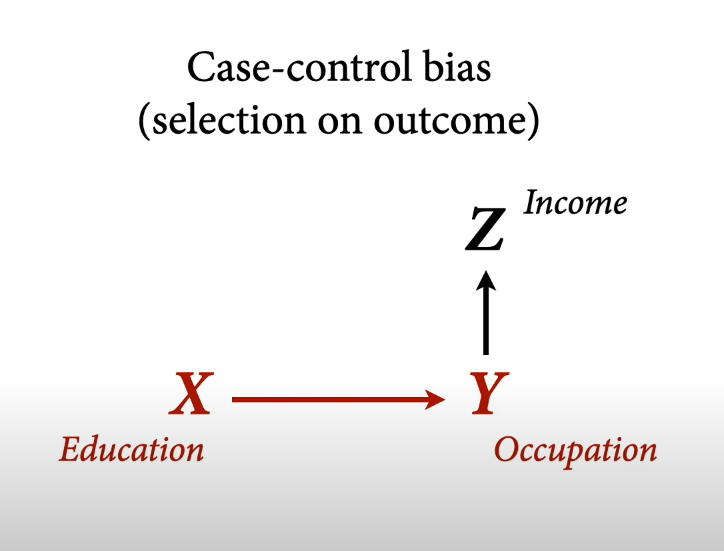

In [16]:
def simulate_case_control_bias(beta_XY=1, beta_YZ=1, n_samples=100):
    # independent variables
    X = stats.norm.rvs(size=n_samples)
    
    # Causal effect of Z on Y (including confound)
    mu_Y = X * beta_XY
    Y = stats.norm.rvs(size=n_samples, loc=mu_Y)
    
    # causal effect of X on Z
    mu_Z = Y * beta_YZ
    Z = stats.norm.rvs(size=n_samples, loc=mu_Z)

    
    # Put data into format for statsmodels
    data = pd.DataFrame(np.vstack([Y, X, Z]).T, columns=["Y", "X", "Z"])
    
    unstratified_model = smf.ols("Y ~ X", data=data).fit()
    stratified_model = smf.ols("Y ~ X + Z", data=data).fit()
    
    return unstratified_model.params.X, stratified_model.params.X

def run_case_control_simulation(beta_XY=1, beta_YZ=1, n_simulations=500, n_samples_per_simualtion=100):
    beta_X = beta_XY

    simulations = np.array(
        [
            simulate_case_control_bias(beta_XY=beta_XY, beta_YZ=beta_YZ, n_samples=n_samples_per_simualtion) 
            for _ in range(n_simulations)
        ]
    )
    _, ax = plt.subplots(figsize=(8, 4))
    az.plot_dist(simulations[:, 0], label='Y ~ X\ncorrect', color='black', ax=ax)
    az.plot_dist(simulations[:, 1], label='Y ~ X + Z\nwrong', color="C0", ax=ax)
    plt.axvline(beta_X, color='k', linestyle='--', label=f'actual={beta_X}')
    plt.legend(loc='upper left')
    plt.xlabel("posterior mean")
    plt.ylabel("density");

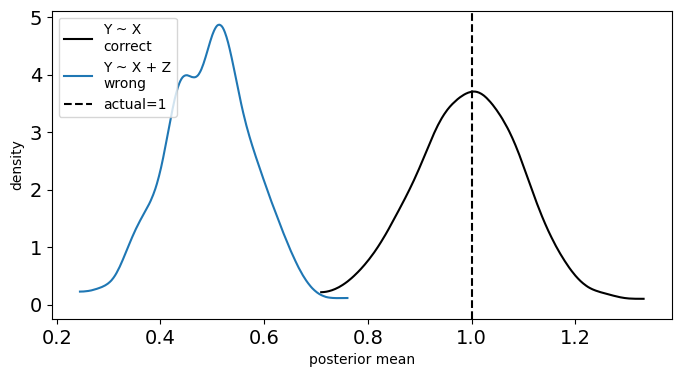

In [17]:
run_case_control_simulation(beta_XY=1, beta_YZ=1)

### Bad Ancestor (aka precision parasite)

Now $Z$ is a parent of $X$

- no backdoor path, $X$ is directly connected to $Y$
- when stratifying by $Z$ you're explaining away variation in $X$, thus reducing the amount of causal information between $X$ and $Y$ that can be explained otherwise.
- **Does not bias your estimate,** but it  **reduces precision**, so estimates will have more uncertainty

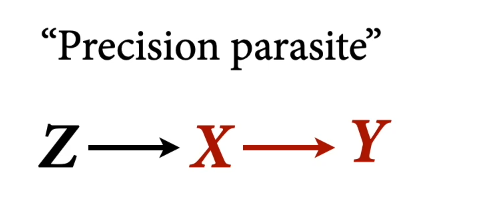


In [18]:
np.random.seed(123)
def simulate_bad_ancestor(beta_ZX=1, beta_XY=1, unobserved_variance=None, n_samples=100):
    Z = stats.norm.rvs(size=n_samples)
    
    mu_X = Z * beta_ZX
    if unobserved_variance is not None:
        u = stats.norm.rvs(size=n_samples) * unobserved_variance
        mu_X += u

    X = stats.norm.rvs(size=n_samples, loc=mu_X)
    
    mu_Y = X * beta_XY
    if unobserved_variance is not None:
        mu_Y += u
        
    Y = stats.norm.rvs(size=n_samples, loc=mu_Y)
    
    data = pd.DataFrame(np.vstack([X, Y, Z]).T, columns=['X', 'Y', 'Z'])
    
    non_stratified_model = smf.ols("Y ~ X", data=data).fit()
    stratified_model = smf.ols("Y ~ X + Z", data=data).fit()
    
    return non_stratified_model.params.X, stratified_model.params.X


def run_bad_ancestor_simulation(beta_ZX=1, beta_XY=1, n_simulations=500, unobserved_variance=None, n_samples_per_simualtion=100):
    beta_X = beta_XY

    simulations = np.array(
        [
            simulate_bad_ancestor(
                beta_ZX=beta_ZX,
                beta_XY=beta_XY,
                unobserved_variance=unobserved_variance,
                n_samples=n_samples_per_simualtion
            ) 
            for _ in range(n_simulations)
        ]
    )
    _, ax = plt.subplots(figsize=(8, 4))
    az.plot_dist(simulations[:, 0], label='Y ~ X\ncorrect', color='black', ax=ax)
    az.plot_dist(simulations[:, 1], label='Y ~ X + Z\nwrong', color="C0", ax=ax)
    plt.axvline(beta_X, color='k', linestyle='--', label=f'actual={beta_X}')
    plt.legend(loc='upper left')
    plt.xlabel("posterior mean")
    plt.ylabel("density");

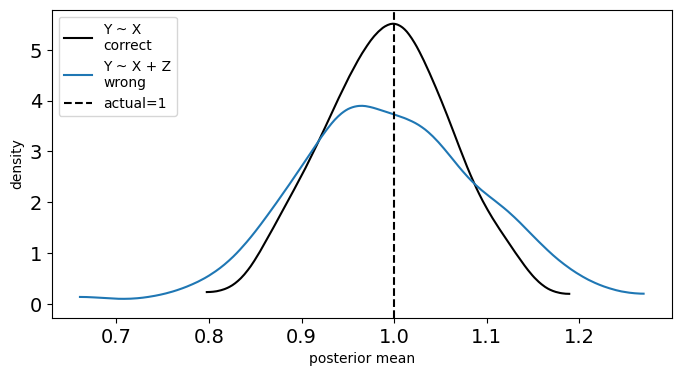

In [19]:
run_bad_ancestor_simulation()

## Bias Amplification

Stratifying on an ancestor when there are other confounders, particularly unobserved forks. **This is like the Bias Parasite scenario, but it also adds bias.**

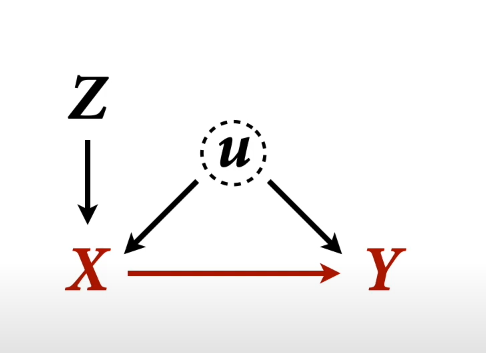

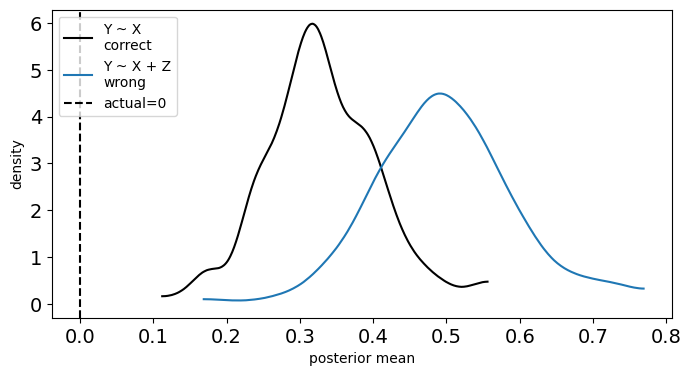

In [20]:
run_bad_ancestor_simulation(beta_ZX=1, beta_XY=0, unobserved_variance=1)

Above we see that both estimators are biased -- even in the best case, we can't observe, and thus control for the the confound $u$. But when stratifying by the ancestor, things are MUCH WORSE.

Hand-wavy explanation:
- in order for $X$ and $Y$ to be associated, their causes need to be associated
- by stratifying by $Z$, we remove the amount of variation in $X$ that is caused by $Z$
- this reduction in variation in $X$ makes the confound $u$ more important comparatively



In [22]:
def simulate_discrete_bias_amplifications(beta_ZX=1, beta_XY=1, n_samples=1000):
    Z = stats.bernoulli.rvs(p=0.5, size=n_samples)
    u = stats.norm.rvs(size=n_samples)

    mu_X = beta_ZX * Z + u
    X = stats.norm.rvs(loc=mu_X, size=n_samples)

    mu_Y = X * beta_XY + u
    Y = stats.norm.rvs(loc=mu_Y, size=n_samples)

    data = pd.DataFrame(np.vstack([u, Z, X, Y]).T, columns=['u', 'Z', 'X', 'Y'])

    models = {}
    models['unstratified'] = smf.ols("Y ~ X", data=data).fit()
    models['z=0'] = smf.ols("Y ~ X", data=data[data.Z == 0]).fit()
    models['z=1'] = smf.ols("Y ~ X", data=data[data.Z == 1]).fit()
    
    return models, data

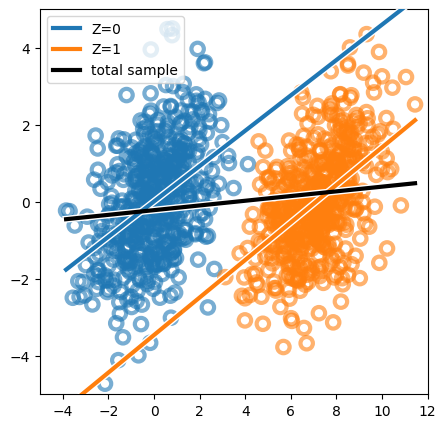

In [23]:
beta_ZX = 7
beta_ZY = 0
models, data = simulate_discrete_bias_amplifications(beta_ZX=beta_ZX, beta_XY=beta_XY)

fig, axs = plt.subplots(figsize=(5, 5))

def plot_linear_model(model, color, label):
    params = model.params
    xs = np.linspace(data.X.min(), data.X.max(), 10)
    ys = params.Intercept + params.X * xs
    utils.plot_line(xs, ys, color=color, label=label)
    
for z in [0, 1]:
    color = f'C{z}'
    utils.plot_scatter(data.X[data.Z==z], data.Y[data.Z==z], color=color)
    model = models[f"z={z}"]
    plot_linear_model(model, color=color, label=f"Z={z}")
    
model = models['unstratified']
plot_linear_model(model, color="k", label=f"total sample")

plt.xlim([-5, 12])
plt.ylim([-5, 5])

plt.legend();


within each level of Z we get a stronger, more biased relationship of X and Y where none exists because true betaXY is 0